## Markov chains for `striplog`

Initially based on [Alfredo Molina on Medium](https://medium.com/@__amol__/markov-chains-with-python-1109663f3678), then incorporating quasi-independence model from Powers & Easterling, https://doi.org/10.1306/212F808F-2B24-11D7-8648000102C1865D. 

In [6]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


def flatten_list(l):
    """
    Unpacks lists in a list:
        [1, 2, [3, 4], [5, [6, 7]]]
    becomes
        [1, 2, 3, 4, 5, 6, 7]
    http://stackoverflow.com/a/12472564/3381305
    """
    if (l == []) or (l is None):
        return []
    if isinstance(l, str):
        return list(l)
    if isinstance(l[0], str):
        return list(''.join(l))
    if isinstance(l[0], list):
        return flatten_list(l[0]) + flatten_list(l[1:])
    return l[:1] + flatten_list(l[1:])

def hollow_matrix(M):
    """
    Return hollow matrix (zeros on diagonal).
    """
    return (1 - np.eye(M.shape[0])) * M




class Markov_chain(object):
    """
    Markov_chain object.
    
    TODO
    - Pretty transition matrix printing with state names and row/col sums.
    - Allow self-transitions.
    - Allow other step sizes (especially 2 and 3).
    - Hidden Markov model?
    - More generally, explore other sequence models, eg LSTM.
    """
    
    def __init__(self, transition_counts, states=None):
        """
        Initialize the MarkovChain instance.
 
        Args
            transition_counts (ndarray): A 2-D array representing the counts
                of change of state in the Markov Chain.
            states (array-like): An array-like representing the possible states
                of the Markov Chain. Must be in the same order as `transition_counts`.
        """
        self.transition_counts = np.atleast_2d(transition_counts)

        if states is not None:        
            self.states = np.asarray(states)
        elif self.transition_counts is not None:
            self.states = np.arange(self.transition_counts.shape[0])
        else:
            self.states = None
                    
        self.expected_counts = self._compute_expected()
            
        return
        
    @staticmethod
    def _compute_freqs(C):
        epsilon = 1e-12
        return (C.T / (epsilon+np.sum(C.T, axis=0))).T
    
    @staticmethod
    def _stop_iter(a, b, tol=0.01):
        a_small = np.all(np.abs(a[-1] - a[-2]) < tol*a[-1])
        b_small = np.all(np.abs(b[-1] - b[-2]) < tol*b[-1])
        return (a_small and b_small)
    
    @property
    def _index_dict(self):
        if self.states is None:
            return {}
        return {self.states[index]: index for index in range(len(self.states))}
    
    @property
    def _state_dict(self):
        if self.states is None:
            return {}
        return {index: self.states[index] for index in range(len(self.states))}
    
    @property
    def transition_freqs(self):
        return self._compute_freqs(self.transition_counts)
    
    @property
    def expected_freqs(self):
        return self._compute_freqs(self.expected_counts)
    
    @property
    def _state_counts(self):
        a = np.sum(m.transition_counts, axis=0)
        b = np.sum(m.transition_counts, axis=1)
        return np.maximum(a, b)

        return counts / np.sum(counts)
 
    @property
    def _state_probs(self):
        return self._state_counts / np.sum(self._state_counts)

    @classmethod
    def from_sequence(cls, sequence, states=None):
        """
        Parse a sequence and make the transition matrix.
        
        Provide upwards sequence.
        """
        sequence = flatten_list(sequence)
        
        if states is None:
            states = sorted(set(sequence))

        n = len(states)
        M = [[0]*n for _ in range(n)]
        
        for seq in np.atleast_2d(sequence):
            integer_seq = [states.index(s) for s in seq]
            for (i, j) in zip(integer_seq, integer_seq[1:]):
                M[i][j] += 1

        return cls(transition_counts=np.array(M), states=states)
    
    def _conditional_probs(self, state):
        """
        Conditional probabilities of each state, given a
        current state.
        """
        return self.transition_freqs[self._index_dict[state]]
 
    def _next_state(self, current_state: str) -> str:
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Args
            current_state (str): The current state of the system.
            
        Returns
            str. One realization of the next state.
        """
        return np.random.choice(self.states, p=self._conditional_probs(current_state))
 
    def generate_states(self, n:int=10, current_state:str=None) -> list:
        """
        Generates the next states of the system.
 
        Args
            n (int): The number of future states to generate.
            current_state (str): The state of the current random variable.
        
        Returns
            list. The next n states.
        """
        if current_state is None:
            current_state = np.random.choice(self.states, p=self._state_probs)

        future_states = []
        for _ in range(n):
            next_state = self._next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states
    
    def _compute_expected(self, max_iter=100, verbose=False, zero_diag=True):
        """
        Compute the independent trials matrix, using method of
        Powers & Easterling 1982.
        """
        m = len(self.states)
        M = self.transition_counts
        a, b = [], []
        
        # Loop 1
        a.append(np.sum(M, axis=1) / (m - 1))
        b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))
        
        i = 2
        while i < max_iter:
            
            if verbose:
                print(f"iteration: {i-1}")
                print(f"a: {a[-1]}")
                print(f"b: {b[-1]}")
                print()

            a.append(np.sum(M, axis=1) / (np.sum(b[-1]) - b[-1]))
            b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))

            # Check for stopping criterion.
            if self._stop_iter(a, b, tol=0.001):
                break

            i += 1
        
        E = a[-1] * b[-1].reshape(-1, 1)
        
        if zero_diag:
            return hollow_matrix(E)
        else:
            return E

    @property
    def degrees_of_freedom(self):
        m = len(self.states)
        return (m - 1)**2 - m
    
    def _critical_chi_squared(self, q=0.95, df=None):
        """
        The chi-squared critical value for a confidence level q
        and degrees of freedom df.
        """
        if df is None:
            df = self.degrees_of_freedom
        return scipy.stats.chi2.ppf(q=q, df=df)
        
    def chi_squared(self, return_crit=True, q=0.95):
        """
        The chi-squared statistic for the given transition
        frequencies. 
        
        Also returns the critical statistic at the given confidence
        level q (default 95%).
        
        If the first number is bigger than the second number,
        then you can reject the hypothesis that the sequence
        is randomly ordered.
        """
        O = self.transition_counts
        E = self.expected_counts
        chi2 = np.sum((O - E)**2 / (E + 1e-12))
        if return_crit:
            return chi2, self._critical_chi_squared(q=q)
        else:
            return chi2
    
    def normalized_difference(self):
        O = self.transition_counts
        E = self.expected_counts
        return (O - E) / np.sqrt(E + 1e-12)
    
    def as_graph(self):
        try:
            import networkx as nx
        except ImportError:
            nx = None 

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        G = nx.from_numpy_array(self.normalized_difference())
        nx.set_node_attributes(G, self._state_dict, 'state')
        return G
    
    def plot_graph(self, ax=None, figsize=None, draw_neg=False):
        try:
            import networkx as nx
        except ImportError:
            nx = None 

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        G = self.as_graph()
        
        return_ax = True
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            return_ax = False
        
        e_neg   = [(u, v) for (u, v, d) in G.edges(data=True) if        d['weight'] <= -1.0]
        e_small = [(u, v) for (u, v, d) in G.edges(data=True) if -1.0 < d['weight'] <=  1.0]
        e_med   = [(u, v) for (u, v, d) in G.edges(data=True) if  1.0 < d['weight'] <=  2.0]
        e_large = [(u, v) for (u, v, d) in G.edges(data=True) if        d['weight'] >   2.0]

        pos = nx.spring_layout(G)

        sizes = 1000 * (self._state_counts / max(self._state_counts))
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color='orange')
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_large, width=10)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_med, width=4)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_small,
                               width=3,
                               alpha=0.1,
                               edge_color='k')
        if draw_neg:
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_neg,
                                   width=2,
                                   alpha=0.1,
                                   edge_color='k')

        labels = nx.get_node_attributes(G, 'state')
        ax = nx.draw_networkx_labels(G, pos, labels=labels, font_size=20, font_family='sans-serif')
        
        if return_ax:
            return ax
        else:
            plt.axis('off')
            return 

## Powers & Easterling data

In [7]:
data = [[ 0, 37,  3,  2],
        [21,  0, 41, 14],
        [20, 25,  0,  0],
        [ 1, 14,  1,  0]]

m = Markov_chain(data, states=['A', 'B', 'C', 'D'])

m.expected_counts

array([[ 0.        , 31.27069125,  8.17143874,  2.55787001],
       [31.28238248,  0.        , 34.05692583, 10.66069169],
       [ 8.17137105, 34.04391563,  0.        ,  2.78471333],
       [ 2.5579797 , 10.65716447,  2.78485582,  0.        ]])

The $\chi^2$ statistic shows the value for the observed ordering, along with the critical value at (by default) the 95% confidence level. If the first number is higher than the second number (ideally much higher), then we can reject the hypothesis that the ordering is quasi-independent. That is, we have shown that the ordering is non-random.

In [8]:
m.chi_squared()

(35.73687369691601, 11.070497693516351)

The normalized difference shows which transitions are 'interesting'. These numbers can be interpreted as standard deviations away from the model of quasi-independence. That is, transitions with large positive numbers represent passages that occur more often than might be expected. Any numbers greater than 2 are likely to be important.

In [9]:
m.normalized_difference()

array([[ 0.        ,  1.02455077, -1.80909811, -0.3488139 ],
       [-1.83841622,  0.        ,  1.18973184,  1.02273667],
       [ 4.13796624, -1.55001803,  0.        , -1.66874603],
       [-0.97412177,  1.02398637, -1.0695517 ,  0.        ]])

We can interpret this as a graph. The transitions from A to C are particularly strong in this one. Transitions from C to A happen less often than we'd expect. Those from B to D and D to B, less so.

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


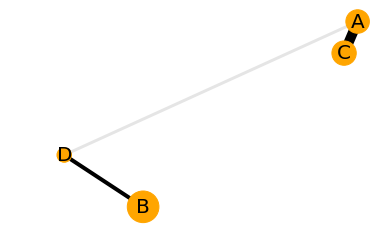

In [10]:
%matplotlib inline
m.plot_graph()

## Data from Matt's thesis

In [11]:
# We need to count transitions here, but without concatenating and creating an incorrect transition.
log7 = [1, 3, 1, 3, 5, 1, 2, 1, 3, 1, 5, 6, 1, 2, 1, 2, 1, 2, 1, 3, 5, 6, 5, 1]
log9 = [1, 3, 1, 5, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 1, 5, 6, 5, 6, 1, 2, 1, 5, 6, 1]
logs = [log9, log7]

m = Markov_chain.from_sequence(log9, states=range(1,12))
m.transition_counts

array([[0, 3, 2, 0, 4, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
data = np.array([  [ 0, 17, 16,  3, 16,  0,  2,  6,  5,  0,  0],
                   [16,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
                   [ 4,  0,  0,  3, 15,  0,  0,  0,  2,  2,  0],
                   [ 0,  0,  2,  0,  4,  0,  0,  0,  0,  0,  0],
                   [19,  0,  5,  0,  0,  9,  0,  8,  6,  1,  0],
                   [ 8,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
                   [ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                   [ 3,  0,  1,  0,  6,  0,  0,  0,  2,  0,  0],
                   [ 5,  0,  1,  0,  5,  0,  0,  0,  0,  5,  3],
                   [ 0,  0,  0,  0,  1,  0,  0,  1,  5,  0,  4],
                   [ 1,  0,  0,  0,  0,  0,  0,  0,  2,  5,  0]])

In [13]:
s = Markov_chain(data, states=range(1,12))

np.set_printoptions(suppress=True, precision=2, linewidth=120)
s.expected_counts

array([[ 0.  ,  5.88,  9.43,  1.98, 19.85,  3.01,  0.65,  4.11,  6.71,  3.73,  2.65],
       [ 6.34,  0.  ,  1.93,  0.41,  4.06,  0.62,  0.13,  0.84,  1.37,  0.76,  0.54],
       [10.51,  1.99,  0.  ,  0.67,  6.74,  1.02,  0.22,  1.39,  2.28,  1.27,  0.9 ],
       [ 2.14,  0.41,  0.65,  0.  ,  1.37,  0.21,  0.04,  0.28,  0.46,  0.26,  0.18],
       [21.06,  3.99,  6.41,  1.35,  0.  ,  2.04,  0.44,  2.79,  4.56,  2.54,  1.8 ],
       [ 3.24,  0.62,  0.99,  0.21,  2.08,  0.  ,  0.07,  0.43,  0.7 ,  0.39,  0.28],
       [ 0.7 ,  0.13,  0.21,  0.04,  0.45,  0.07,  0.  ,  0.09,  0.15,  0.08,  0.06],
       [ 5.48,  1.04,  1.67,  0.35,  3.51,  0.53,  0.11,  0.  ,  1.19,  0.66,  0.47],
       [ 8.29,  1.57,  2.52,  0.53,  5.31,  0.8 ,  0.17,  1.1 ,  0.  ,  1.  ,  0.71],
       [ 4.72,  0.9 ,  1.44,  0.3 ,  3.03,  0.46,  0.1 ,  0.63,  1.02,  0.  ,  0.4 ],
       [ 2.51,  0.48,  0.76,  0.16,  1.61,  0.24,  0.05,  0.33,  0.54,  0.3 ,  0.  ]])

In [14]:
s.normalized_difference()

array([[ 0.  ,  4.59,  2.14,  0.72, -0.86, -1.73,  1.67,  0.93, -0.66, -1.93, -1.63],
       [ 3.84,  0.  , -0.67, -0.64, -2.02, -0.78, -0.36, -0.92, -1.17, -0.87, -0.74],
       [-2.01, -1.41,  0.  ,  2.84,  3.18, -1.01, -0.47, -1.18, -0.18,  0.65, -0.95],
       [-1.46, -0.64,  1.67,  0.  ,  2.25, -0.46, -0.21, -0.53, -0.68, -0.51, -0.43],
       [-0.45, -2.  , -0.56, -1.16,  0.  ,  4.86, -0.66,  3.12,  0.67, -0.97, -1.34],
       [ 2.64, -0.78,  0.01, -0.46, -1.44,  0.  , -0.26, -0.66, -0.84, -0.63, -0.53],
       [ 1.55, -0.36, -0.46, -0.21, -0.67, -0.26,  0.  , -0.3 , -0.39, -0.29, -0.25],
       [-1.06, -1.02, -0.52, -0.59,  1.33, -0.73, -0.34,  0.  ,  0.75, -0.81, -0.68],
       [-1.14, -1.25, -0.96, -0.73, -0.13, -0.9 , -0.42, -1.05,  0.  ,  4.  ,  2.72],
       [-2.17, -0.95, -1.2 , -0.55, -1.17, -0.68, -0.31,  0.47,  3.93,  0.  ,  5.65],
       [-0.95, -0.69, -0.87, -0.4 , -1.27, -0.49, -0.23, -0.58,  1.97,  8.54,  0.  ]])

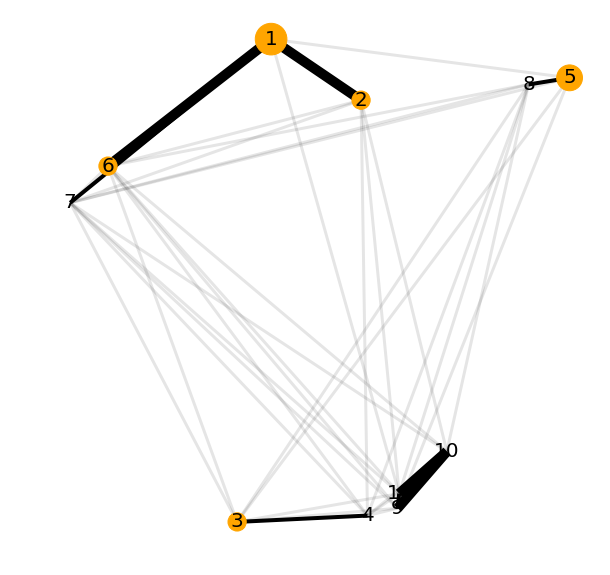

In [15]:
s.plot_graph(figsize=(10,10))

## Fake data

In [16]:
data = "sssmmmlllmlmlsslsllsmmllllmssssllllssmmlllllssssssmmmmsmllllssslmslmsmmmslsllll"""

In [17]:
m = Markov_chain.from_sequence(data)

In [18]:
m.transition_counts

array([[19,  5,  7],
       [ 6,  9,  5],
       [ 7,  6, 14]])

In [19]:
m._state_probs

array([0.41, 0.25, 0.34])

In [20]:
m.transition_freqs

array([[0.61, 0.16, 0.23],
       [0.3 , 0.45, 0.25],
       [0.26, 0.22, 0.52]])

In [21]:
m.expected_freqs

array([[0.  , 0.39, 0.61],
       [0.62, 0.  , 0.38],
       [0.72, 0.28, 0.  ]])

In [22]:
m.states

array(['l', 'm', 's'], dtype='<U1')

In [23]:
m._conditional_probs('l')

array([0.61, 0.16, 0.23])

In [24]:
m.generate_states(20)

['m',
 'm',
 'm',
 'm',
 'm',
 'l',
 'l',
 'l',
 'l',
 'l',
 'l',
 'm',
 's',
 'l',
 'l',
 's',
 'm',
 's',
 'l',
 'l']